<p href"https://github.com/Luisguiv" style="color: black"><b>Autor: Luis Guilherme Vosgerau Baroni</b></p>
<p style="color: black"><b>Data limite: 08/04/2022</b></p> 
<header style="width: 100%; background-color: #70111f">
<a href="https://www.i2a2.ca/"><img style="padding: 0; margin: 0" src="https://static.wixstatic.com/media/b12e17_8ca034d8e1e54c7481d4de3f5d76046e~mv2_d_2198_1330_s_2.png/v1/fill/w_333,h_200,al_c,usm_0.66_1.00_0.01,enc_auto/Logo_I2A2_fundo_preto.png"></a>
</header>
<p style="width: 100%; color: black; font-size: 25px"><b>I2A2 - Institut d'Intelligence Artificielle Appliquée</b></p>
<p style="width: 90%; color: black; font-size: 22px">Desafio 2 - Determinar parentesco entre indivíduos</p>
<br>
<p style="color: black">Referências e Apoio</p>
<li style="color: black" href="https://www.youtube.com/watch?v=Lsue2gEM9D0&ab_channel=StatQuestwithJoshStarmer">StatQuest with Josh Starmer</li>
<li style="color: black" href="https://github.com/onediojunior"><a style="color: black">Onédio Siqueira SEABRA Junior</a></li>

In [1]:
!pip install pandas pyarrow

In [2]:
!pip install factor_analyzer

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# pandas collumns and rows def
pd.options.display.max_columns = 15
pd.options.display.max_rows = 200

#supress futurewarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [4]:
df_count = pd.read_excel("readcounts.xlsx")
df_count.sample(5)

,Unnamed: 0,H223,H224,H225,H226,H227,H228,...,H264,H265,H266,H267,H268,H269,H270
46732,ENSG00000257095,0,0,0,0,0,0,...,0,0,0,0,0,0,0
37339,ENSG00000238156,0,0,0,0,0,0,...,0,0,0,0,0,0,0
51778,ENSG00000264742,0,0,0,0,0,0,...,0,0,0,0,0,0,0
6734,ENSG00000133119,47,33,23,136,14,12,...,18,4,65,10,3,13,37
54326,ENSG00000268581,9,13,6,1,19,7,...,19,13,4,19,41,27,9


In [5]:
print("Genes: ", df_count.value_counts().sum())

Genes:  65215


In [6]:
if not df_count.isnull().values.any():
  print("No missing values!")
else:
  print("There're missing values!")

No missing values!


In [7]:
df_cpy = df_count.copy()
df_cpy.sample(len(df_cpy))

,Unnamed: 0,H223,H224,H225,H226,H227,H228,...,H264,H265,H266,H267,H268,H269,H270
25277,ENSG00000222629,0,0,0,0,0,0,...,0,0,0,1,0,0,0
45519,ENSG00000254937,0,0,0,1,0,0,...,0,0,0,0,0,0,0
30770,ENSG00000229903,0,0,0,0,0,0,...,0,0,0,0,0,0,0
5847,ENSG00000126602,418,569,689,292,85,90,...,131,369,324,126,105,109,483
26516,ENSG00000224523,0,2,2,1,0,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51743,ENSG00000264697,0,0,1,0,0,0,...,0,0,0,0,0,0,0
40805,ENSG00000248646,0,0,0,0,0,0,...,0,0,0,0,0,0,0
40747,ENSG00000248554,2,2,0,0,0,0,...,0,0,0,0,0,0,0
56476,ENSG00000272659,0,0,0,1,0,1,...,0,1,1,0,1,0,0


In [8]:
df_cpy["MISS"] = df_cpy.sum(axis=1)
df_cpy.head(3)

,Unnamed: 0,H223,H224,H225,H226,H227,H228,...,H265,H266,H267,H268,H269,H270,MISS
0,ENSG00000000003,0,0,0,1,0,0,...,0,2,0,0,1,0,12
1,ENSG00000000005,0,0,0,0,0,0,...,0,0,0,0,0,0,2
2,ENSG00000000419,1216,1228,1022,912,491,449,...,484,926,803,630,537,582,34038


In [9]:
df_ausentes = df_cpy[df_cpy.MISS == 0]
print(f"Ensambles missing: {df_ausentes.shape[0]}")

Ensambles missing: 20537


In [10]:
df_cpy = df_cpy[df_cpy.MISS != 0]

print(f"Ensambles: {df_cpy.shape[0]}")

Ensambles: 44678


In [11]:
df_cpy.drop('MISS', axis='columns',inplace=True)

In [12]:
print("Genes: ", df_cpy.value_counts().sum())

Genes:  44678


In [13]:
df_cpy.index = df_cpy["Unnamed: 0"]
df_cpy.drop('Unnamed: 0', axis=1, inplace=True)
# imprimir as 5 primeiras linhas
df_cpy.head()

,H223,H224,H225,H226,H227,H228,H229,...,H264,H265,H266,H267,H268,H269,H270
Unnamed: 0,,,,,,,,,,,,,,,
ENSG00000000003,0,0,0,1,0,0,0,...,1,0,2,0,0,1,0
ENSG00000000005,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
ENSG00000000419,1216,1228,1022,912,491,449,466,...,450,484,926,803,630,537,582
ENSG00000000457,189,114,110,289,186,148,169,...,90,105,275,101,56,87,81
ENSG00000000460,74,38,55,127,30,17,45,...,20,15,139,54,25,21,47


In [14]:
df_cpy = df_cpy.T
df_scaled = preprocessing.scale(df_cpy)

In [15]:
pca = PCA(n_components = 22)
pca.fit(df_scaled)
pca_data = pca.transform(df_scaled)

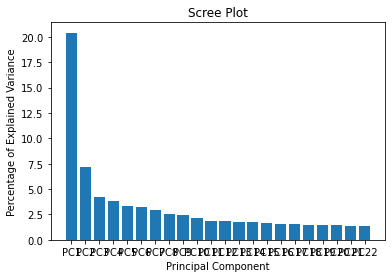

In [16]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

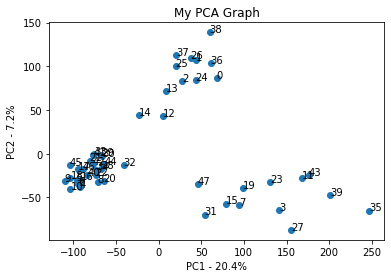

In [17]:
pca_df = pd.DataFrame(pca_data, columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()

In [18]:
loading_scores = pd.Series(pca.components_[0])

sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_genes = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_genes])

12231    0.010273
5072     0.010257
7737     0.010231
10409    0.010230
15637    0.010216
2711     0.010211
12276    0.010204
8965     0.010198
7176     0.010193
609      0.010191
dtype: float64


In [19]:
loading_scores.head()

0    0.003010
1   -0.000083
2    0.006091
3    0.007108
4    0.008599
dtype: float64

In [20]:
X = df_cpy.iloc[:,0:].values

X

array([[   0,    0, 1216, ...,    1,    0,    0],
       [   0,    0, 1228, ...,    1,    0,    0],
       [   0,    0, 1022, ...,    0,    0,    0],
       ...,
       [   0,    0,  630, ...,    0,    0,    0],
       [   1,    0,  537, ...,    0,    0,    0],
       [   0,    0,  582, ...,    0,    0,    0]], dtype=int64)

In [21]:
kmeans = KMeans(n_clusters = 8, init = 'random') 

In [22]:
kmeans.fit(X)

KMeans(init='random')

In [23]:
kmeans.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 9.86500000e+02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-01, 0.00000000e+00, 4.37400000e+02, ...,
        1.60000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.50000000e-01, 0.00000000e+00, 6.43250000e+02, ...,
        7.50000000e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.83333333e-01, 0.00000000e+00, 7.54083333e+02, ...,
        1.08333333e+00, 8.33333333e-02, 0.00000000e+00],
       [2.00000000e-01, 0.00000000e+00, 6.54800000e+02, ...,
        8.00000000e-01, 2.00000000e-01, 0.00000000e+00],
       [1.66666667e-01, 6.93889390e-18, 6.05166667e+02, ...,
        5.00000000e-01, 6.93889390e-18, 3.46944695e-18]])

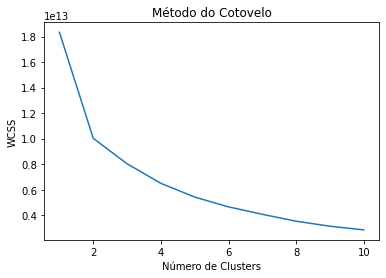

In [24]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
kmeans3 = KMeans(n_clusters = 3, init = 'random') 

In [26]:
kmeans3.fit(X)

KMeans(init='random', n_clusters=3)

In [27]:
kmeans3.cluster_centers_

array([[1.25000000e-01, 1.25000000e-01, 4.94625000e+02, ...,
        1.87500000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.87500000e-01, 6.93889390e-18, 6.14875000e+02, ...,
        6.87500000e-01, 6.25000000e-02, 3.46944695e-18],
       [3.33333333e-01, 4.16666667e-02, 8.43458333e+02, ...,
        9.58333333e-01, 4.16666667e-02, 4.16666667e-02]])

In [28]:
kmeans4 = KMeans(n_clusters = 4, init = 'random') 

In [29]:
kmeans4.fit(X)

KMeans(init='random', n_clusters=4)

In [30]:
kmeans4.cluster_centers_

array([[ 3.33333333e-01,  4.16666667e-02,  8.43458333e+02, ...,
         9.58333333e-01,  4.16666667e-02,  4.16666667e-02],
       [ 2.00000000e-01,  0.00000000e+00,  6.37000000e+02, ...,
         4.00000000e-01,  2.00000000e-01,  0.00000000e+00],
       [ 1.25000000e-01,  1.25000000e-01,  4.94625000e+02, ...,
         1.87500000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.81818182e-01, -6.93889390e-18,  6.04818182e+02, ...,
         8.18181818e-01, -6.93889390e-18, -3.46944695e-18]])

In [31]:
modelo_v1 = KMeans(n_clusters=3, init='random')
modelo_v1.fit(X)

KMeans(init='random', n_clusters=3)

In [32]:
labels = modelo_v1.labels_

print(f"Silhouette Score (K=3) : {silhouette_score(X, labels, metric='euclidean')}")

Silhouette Score (K=3) : 0.32750348548917674


In [33]:
modelo_v2 = KMeans(n_clusters=4, init='random')
modelo_v2.fit(X)

KMeans(init='random', n_clusters=4)

In [34]:
labels = modelo_v2.labels_

print(f"Silhouette Score (K=4) : {silhouette_score(X, labels, metric='euclidean')}")

Silhouette Score (K=4) : 0.37529543577461205


In [35]:
modelo_v3 = KMeans(n_clusters=8, init='random')
modelo_v3.fit(X)

KMeans(init='random')

In [36]:
labels = modelo_v3.labels_

print(f"Silhouette Score (K=8) : {silhouette_score(X, labels, metric='euclidean')}")

Silhouette Score (K=8) : 0.3207374026068212


In [37]:
# reconstroi o DataFrame com o atributo FAMILIA

# cria lista com o nome dos atributos
atributos = df_cpy.columns
# cria lista com o nome dos dos índices
indices = df_cpy.index
cluster_final = pd.DataFrame(X, columns= atributos, index=indices)

# cria mais um atributo especificando a família do indivíduo
cluster_final["FAMILIA"] = modelo_v1.labels_

In [38]:
cluster_final.sample(5)

Unnamed: 0,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,...,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281918,ENSG00000281920,FAMILIA
H268,0,0,630,56,25,4823,8,...,2,1,0,0,0,0,2
H230,0,0,727,258,100,7668,4,...,1,0,0,2,0,0,0
H251,0,0,547,178,31,19576,2,...,17,0,0,0,0,0,1
H228,0,0,449,148,17,6856,16,...,1,0,0,5,0,0,2
H234,1,0,1111,248,99,12703,6,...,3,0,4,2,0,0,0


In [39]:
familias = cluster_final["FAMILIA"].unique()
# cabecalho
print("="*130)
for familia in familias:
  individuos = cluster_final[cluster_final["FAMILIA"] == familia]
  print(f"\nFamily {int(familia) + 1} : {individuos.index.values}\n")
  print(f"Total family members : {len(individuos)}\n")
  print("********************".center(130))
print("="*130)


Family 1 : ['H223' 'H224' 'H225' 'H226' 'H230' 'H234' 'H235' 'H236' 'H237' 'H238'
 'H242' 'H246' 'H247' 'H248' 'H249' 'H250' 'H254' 'H258' 'H259' 'H260'
 'H261' 'H262' 'H266' 'H270']

Total family members : 24

                                                       ********************                                                       

Family 2 : ['H227' 'H231' 'H233' 'H239' 'H241' 'H243' 'H245' 'H251' 'H255' 'H257'
 'H263' 'H264' 'H265' 'H267' 'H269']

Total family members : 15

                                                       ********************                                                       

Family 3 : ['H228' 'H229' 'H232' 'H240' 'H244' 'H252' 'H253' 'H256' 'H268']

Total family members : 9

                                                       ********************                                                       
